In [36]:
import os
import numpy as np
import sys
import itertools
from statistics import mean
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sys.path.append('..')

In [2]:
os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=fusible"
os.environ['CUDA_CACHE_DISABLE'] = '0'
os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'
os.environ['TF_ADJUST_HUE_FUSED'] = '1'
os.environ['TF_ADJUST_SATURATION_FUSED'] = '1'
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
os.environ['TF_AUTOTUNE_THRESHOLD'] = '2'
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()
tf.disable_v2_behavior()
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

import horovod.tensorflow as hvd
hvd.init()

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[hvd.rank()], True)
tf.config.set_visible_devices(physical_devices[hvd.rank()], 'GPU')
devices = tf.config.list_logical_devices('GPU')

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from mask_rcnn.hyperparameters import dataset_params
from mask_rcnn.hyperparameters import mask_rcnn_params
from mask_rcnn import dataset_utils
from mask_rcnn import dataloader
from mask_rcnn import mask_rcnn_model
import load_weights, model_v2

In [4]:
train_file_pattern = '/home/ubuntu/data/coco/tf_record/train*'
orig_file_pattern = '/home/ubuntu/data/coco/nv_example_tfr/train*'
batch_size = 4
data_params = dataset_params.get_data_params()
params = mask_rcnn_params.default_config().values()
data_params['batch_size'] = batch_size
params['finetune_bn'] = False
params['train_batch_size'] = batch_size
params['l2_weight_decay'] = 1e-4
params['init_learning_rate'] = 2e-3 * batch_size
params['warmup_learning_rate'] = 2e-4 * batch_size
params['warmup_steps'] = 1000
params['learning_rate_steps'] = [30000,40000]
params['learning_rate_levels'] = [2e-4 * batch_size, 2e-5 * batch_size]
params['momentum'] = 0.9
params['use_batched_nms'] = False
params['use_custom_box_proposals_op'] = True
params['amp'] = True
params['include_groundtruth_in_features'] = True

In [5]:
orig_loader = dataloader.InputReader(orig_file_pattern, use_instance_mask=True)
orig_tdf = orig_loader(data_params)
orig_iter = orig_tdf.make_initializable_iterator()
orig_features, orig_labels = orig_iter.get_next()

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


In [6]:
mask_rcnn = model_v2.MRCNN(params)

In [7]:
train_outputs = model_v2.model_fn(orig_features, orig_labels, params, mask_rcnn, is_training=True)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
[MaskRCNN] INFO    : [Training Compute Statistics] 570.6 GFLOPS/image
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
predictions = model_v2.model_fn(orig_features, orig_labels, params, mask_rcnn, is_training=False)

[MaskRCNN] INFO    : [Inference Compute Statistics] 2200.0 GFLOPS/image


In [9]:
var_list = load_weights.build_assigment_map('mrcnn/resnet50/')
checkpoint_file = tf.train.latest_checkpoint('../resnet/resnet-nhwc-2018-02-07/')
_init_op, _init_feed_dict = load_weights.assign_from_checkpoint(checkpoint_file, var_list)

In [10]:
sess = tf.Session()
sess.run(orig_iter.initializer)
sess.run(tf.global_variables_initializer())
sess.run(_init_op, _init_feed_dict)
#saver = tf.train.Saver()
#saver.restore(sess,tf.train.latest_checkpoint('saved_model/'))

[GPU 00] Restoring pretrained weights (265 Tensors) from: ../resnet/resnet-nhwc-2018-02-07/model.ckpt-112603


In [11]:
outputs = sess.run(train_outputs)
pred = sess.run(predictions)

In [71]:
p_bar = tqdm(range(2000))
loss_history = []
rpn_loss_history = []
rcnn_loss_history = []
for i in p_bar:
    outputs = sess.run(train_outputs)
    loss_history.append(outputs[1])
    rpn_loss_history.append(outputs[2])
    rcnn_loss_history.append(outputs[4])
    smoothed_loss = mean(loss_history[-50:])
    smoothed_rpn_loss = mean(rpn_loss_history[-50:])
    smoothed_rcnn_loss = mean(rcnn_loss_history[-50:])
    p_bar.set_description("L: {0:.4f}, R: {1:.4f}, C: {2:.4f}, LR: {3:.4f}".format(smoothed_loss,
                                                                                   smoothed_rpn_loss,
                                                                                   smoothed_rcnn_loss,
                                                                                   outputs[6]))

L: 1.8286, R: 0.0444, C: 0.3904, LR: 0.0080: 100%|██████████| 2000/2000 [06:45<00:00,  4.93it/s]


In [72]:
pred = sess.run(predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


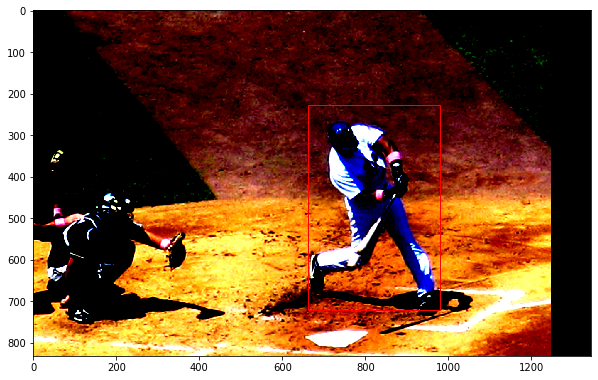

In [78]:
image_num=1
box_num=0
#plt.imshow(pred['images'][2])
fig,ax = plt.subplots(1, figsize=(10,10))
# Display the image
ax.imshow(pred['images'][image_num])
# Create a Rectangle patch
box = pred['detection_boxes'][image_num][box_num]
rect = patches.Rectangle((box[1],box[0]),
                         box[3]-box[1],
                         box[2]-box[0],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

In [74]:
pred['detection_boxes'][2][0]

array([304.0379 , 225.8822 , 546.0134 , 938.68713], dtype=float32)

In [69]:
pred['detection_classes'][2][0]

1.0

In [70]:
pred['detection_scores'][2]

array([0.8971574 , 0.8717761 , 0.861119  , 0.83561504, 0.8001409 ,
       0.75797594, 0.7152739 , 0.58861446, 0.58724934, 0.56314373,
       0.51116014, 0.44292697, 0.4381958 , 0.319434  , 0.31495062,
       0.31220534, 0.3024696 , 0.2904557 , 0.29031673, 0.27671814,
       0.2652621 , 0.25424924, 0.25164327, 0.24870473, 0.23413613,
       0.23242211, 0.20539302, 0.2023603 , 0.19652493, 0.19209011,
       0.17849043, 0.17523853, 0.17065114, 0.16247505, 0.16138446,
       0.15903771, 0.15539742, 0.15379275, 0.15285175, 0.15094878,
       0.15040351, 0.15026097, 0.14945556, 0.14865015, 0.14483717,
       0.14072284, 0.13829179, 0.13752824, 0.13361466, 0.132561  ,
       0.1303372 , 0.13025935, 0.11229485, 0.11052124, 0.10795426,
       0.1073258 , 0.10523446, 0.10202841, 0.09934029, 0.09786235,
       0.09695039, 0.09488292, 0.09405854, 0.09366245, 0.09317555,
       0.09315431, 0.09112156, 0.09086085, 0.09074214, 0.08933957,
       0.08924878, 0.08616405, 0.08609378, 0.08533136, 0.08309